In [1]:
import torch
import open_clip
from PIL import Image
import numpy as np


device = "cuda" if torch.cuda.is_available() else "cpu"

# Chọn model mạnh hơn: ViT-g-14 (huấn luyện trên LAION-2B)cái 
model_name = "ViT-SO400M-16-SigLIP2-384"
pretrained = "webli"

# Load model + preprocess
model, _, preprocess = open_clip.create_model_and_transforms(
    model_name=model_name,
    pretrained=pretrained,
    device=device
)

# Load tokenizer cho text
tokenizer = open_clip.get_tokenizer(model_name)


d:\Summer_2025\AIC\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


: 

In [ ]:
def extract_image_features(image_path):
    image = Image.open(image_path).convert("RGB")
    
    image_input = preprocess(image).to(device).unsqueeze(0)
    
    with torch.no_grad():
        image_features = model.encode_image(image_input)
    
    image_features /= image_features.norm(dim=-1, keepdim=True)
    
    return image_features.cpu().detach().numpy()

In [56]:
def _to_pil(img_like):
    if isinstance(img_like, str):
        with Image.open(img_like) as im:
            return im.convert("RGB").copy()
    elif isinstance(img_like, Image.Image):
        return img_like.convert("RGB").copy()
    else:
        raise TypeError(f"Unsupported type for image: {type(img_like)}")

In [6]:
@torch.no_grad()
def embed_images(images):
    # pil_img = _to_pil(images)
    batch = torch.stack([preprocess(img) for img in images]).to(device)
    feats = model.encode_image(batch).float()
    return feats.cpu().numpy().astype("float16")

In [ ]:
file_img = r'D:\Summer_2025\AIC\Data_extraction\Keyframes_2025\Keyframes_L21/keyframes\L21_V001\005.jpg'
imgs = Image.open(file_img).convert("RGB").copy()
test_img = embed_images([imgs])

In [8]:
text = 'a man sitting on a motorbike' # query voi text nay , chay ben file query cuxng duoc
# oke anh, de em ngoi lam anh a.
te = text_embed(text)

In [67]:
te.shape

(1, 1152)

In [8]:
import numpy as np
file = r'D:\Summer_2025\AIC\Data_extraction\features\L21_V001.npy'
a = np.load(file)

In [14]:
a[4]

array([ 0.006508,  0.0324  ,  0.00977 , ...,  0.005356, -0.0218  ,
        0.0423  ], dtype=float16)

In [17]:
a.shape

(307, 1152)

In [34]:
import faiss
dim = a.shape[1]
index = faiss.IndexFlatIP(dim)
index.add(a)
index.ntotal

307

In [27]:
test = test.astype("float32")

In [28]:
test

array([ 0.00650787,  0.03240967,  0.00977325, ...,  0.00535583,
       -0.02180481,  0.04229736], dtype=float32)

In [29]:
test.shape

(1152,)

In [71]:
D, I = index.search(te, k=3) # neeus tra ve `38` laf ok 

In [72]:
D,I

(array([[0.11039707, 0.10580194, 0.10005827]], dtype=float32),
 array([[ 38, 165, 168]], dtype=int64))

In [ ]:
# index = faiss.read_index(INDEX_PATH)
# # tăng recall nếu cần
# faiss.ParameterSpace().set_index_parameter(index, "nprobe", 256)
import ujson
conn = sqlite3.connect(SQLITE_DB)

def search_vec(vec, k=10):
    D, I = index.search(vec, k)
    out = []
    for s, idx in zip(D[0].tolist(), I[0].tolist()):
        if idx == -1: continue
        row = conn.execute("SELECT path, payload FROM docs WHERE id=?", (int(idx),)).fetchone()
        if row:
            out.append({"id": int(idx), "score": float(s), "path": row[0], "payload": ujson.loads(row[1])})
    return out

In [78]:
CTX_LEN = int(model.text.positional_embedding.shape[0])

def tokenize_texts(texts):
    try:
        toks = open_clip.tokenize(texts, context_length=CTX_LEN, truncate=True)
    except TypeError:
        # Fallback cho bản open-clip cũ không có 'truncate'
        toks = open_clip.tokenize(texts, context_length=CTX_LEN)
        # đảm bảo đúng [B, CTX_LEN]
        if toks.shape[1] > CTX_LEN:
            toks = toks[:, :CTX_LEN]
        elif toks.shape[1] < CTX_LEN:
            pad = torch.zeros((toks.shape[0], CTX_LEN - toks.shape[1]), dtype=toks.dtype)
            toks = torch.cat([toks, pad], dim=1)
    return toks

In [1]:
import torch.nn.functional as F
USE_COSINE = False
@torch.no_grad()
def embed_text(texts):
    toks = tokenizer(texts).to(device)
    feats = model.encode_text(toks).float()
    if USE_COSINE:
        feats = F.normalize(feats, dim=-1)
    return feats.cpu().numpy().astype("float16")

NameError: name 'torch' is not defined

In [90]:
text_test = 'a man sitting on a motorbike'
te_test = embed_text(text_test)

In [91]:
te_test.shape

(1, 1152)

In [92]:
D, I = index.search(te_test, 3)

In [93]:
D,I

(array([[0.11039121, 0.10579748, 0.10005896]], dtype=float32),
 array([[ 38, 165, 168]], dtype=int64))

In [48]:
def text_embed(text: str):

    ###### TEXT FEATURES EXTRACTING ######
    text = tokenizer([text]).to(device)
    text_features = model.encode_text(text)

    text_features /= text_features.norm(dim=-1, keepdim=True)
    text_features = text_features.cpu().detach().numpy()
    if text_features.ndim == 2 and text_features.shape[0] == 1:
        text_features = text_features.squeeze(0)   # từ (1,1152) -> (1152,)
    elif text_features.ndim == 2 and text_features.shape[1] == 1:
        text_features = text_features.squeeze(1)   # từ (1152,1) -> (1152,)   
    text_features = text_features.astype(np.float32)
    text_features /= np.linalg.norm(text_features) + 1e-6
    return text_features


In [36]:
import google.generativeai as genai
from deep_translator import GoogleTranslator
from openai import OpenAI
from dotenv import load_dotenv
import os

load_dotenv()

def translate_text_GoogleTranslate(text, target_language="en"):
    """
    Translates the input text from the source language to the target language.

    :param text: The text to be translated
    :param to_lang: The language code of the target language (default is English 'en')
    :return: The translated text or error message.
    """
    translation = GoogleTranslator(source='auto', target='en').translate(text)
    print("✅ Translation by Google Translate Library")
    return translation

In [24]:
text = text_embed("a man riding a motorcycle on a highway")
text.shape

(1152,)

In [42]:
import json
import os
def search_video(text_query, k=5, feature_dir=None, root_keyframes=None):
    text = translate_text_GoogleTranslate(text_query)
    print(text)
    text = text_embed(text)
    mapping = json.load(open("D:/Summer_2025/AIC/Data_extraction/features/video2folder.json"))
    
    results = []
    for file in sorted(os.listdir(feature_dir)):
        if file.endswith(".npy"):
            subdir = file.replace(".npy", "")
            path = os.path.join(feature_dir, file)
            video_feats = np.load(path)  # shape: (num_frames, 1024)

            if video_feats.dtype != np.float32:
                video_feats = video_feats.astype(np.float32)
            norms = np.linalg.norm(video_feats, axis=1, keepdims=True)
            video_feats /= np.clip(norms, a_min=1e-6, a_max=None)

            sims = np.dot(video_feats, text)  # (num_frames,)
            max_idx = int(np.argmax(sims))
            max_score = float(sims[max_idx])

            # Tìm tên file ảnh tương ứng (nếu cần)
            best_img = None
            if root_keyframes:
                folder = mapping.get(subdir, "???")
                img_dir = os.path.join(root_keyframes, folder, "keyframes", subdir)
                if os.path.exists(img_dir):
                    jpgs = sorted([f for f in os.listdir(img_dir) if f.endswith(".jpg")])
                    if max_idx < len(jpgs):
                        best_img = os.path.join(img_dir, jpgs[max_idx])

            results.append({
                "video": subdir,
                "folder": mapping.get(subdir, "???"),
                "score": max_score,
                "best_frame_index": max_idx,
                "best_frame_file": best_img
            })

    results.sort(key=lambda x: x["score"], reverse=True)

    # Hiển thị kết quả
    print(f"\n🎯 Top {k} kết quả cho truy vấn: \"{text_query}\"\n")
    for r in results[:k]:
        print(f"✅ Video {r['video']} trong {r['folder']}: score = {r['score']:.4f} → frame {r['best_frame_index']} → {r['best_frame_file'] or 'Không tìm thấy ảnh'}")

        # Hiển thị ảnh nếu có (Kaggle/Jupyter)
        if r['best_frame_file'] and os.path.exists(r['best_frame_file']):
            try:
                display(Image.open(r['best_frame_file']).resize((320, 180)))
            except Exception as e:
                print(f"⚠️ Không thể hiển thị ảnh: {e}")

    return results[:k]



✅ Translation by Google Translate Library
A bait is dropping in the water. This bait looks like a fish, silver. Next, the scene moved to a person who made the movement up and down the fishing rod. This person is wearing a white hat. The video of the surrounding scene is also many people who are catching fish. Someone caught a fish and this fish struggled when the fishing was raised.

🎯 Top 10 kết quả cho truy vấn: "Một chiếc mồi câu đang thả xuống dưới nước. Miếng mồi này nhìn giống một con cá, màu bạc. Tiếp theo cảnh chuyển qua một người làm động tác nâng lên hạ xuống chiếc cần câu. Người này đang đội nón trắng. Video quay cảnh xung quanh thì cũng có nhiều người đang bắt cá. Có người bắt được một con cá và con cá này vùng vẫy khi bị câu lên."

✅ Video L28_V003 trong Keyframes_L28: score = 0.1760 → frame 61 → D:/Summer_2025/AIC/Data_extraction/Keyframes_2025/Keyframes_L28\keyframes\L28_V003\062.jpg


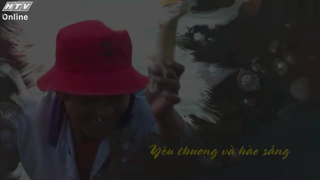

✅ Video L28_V004 trong Keyframes_L28: score = 0.1733 → frame 43 → D:/Summer_2025/AIC/Data_extraction/Keyframes_2025/Keyframes_L28\keyframes\L28_V004\044.jpg


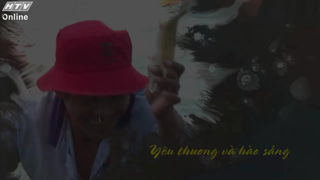

✅ Video L28_V012 trong Keyframes_L28: score = 0.1703 → frame 53 → D:/Summer_2025/AIC/Data_extraction/Keyframes_2025/Keyframes_L28\keyframes\L28_V012\054.jpg


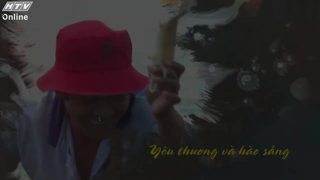

✅ Video L28_V011 trong Keyframes_L28: score = 0.1696 → frame 61 → D:/Summer_2025/AIC/Data_extraction/Keyframes_2025/Keyframes_L28\keyframes\L28_V011\062.jpg


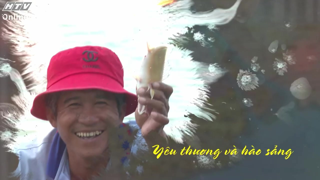

✅ Video L28_V017 trong Keyframes_L28: score = 0.1695 → frame 63 → D:/Summer_2025/AIC/Data_extraction/Keyframes_2025/Keyframes_L28\keyframes\L28_V017\064.jpg


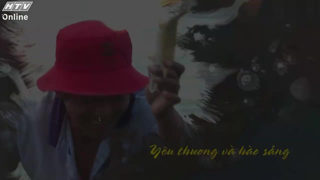

✅ Video L28_V009 trong Keyframes_L28: score = 0.1668 → frame 44 → D:/Summer_2025/AIC/Data_extraction/Keyframes_2025/Keyframes_L28\keyframes\L28_V009\045.jpg


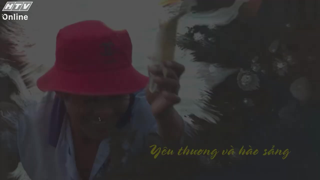

✅ Video L28_V018 trong Keyframes_L28: score = 0.1661 → frame 63 → D:/Summer_2025/AIC/Data_extraction/Keyframes_2025/Keyframes_L28\keyframes\L28_V018\064.jpg


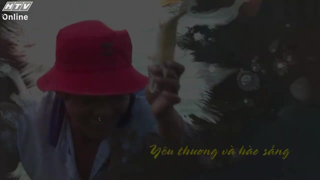

✅ Video L27_V015 trong Keyframes_L27: score = 0.1654 → frame 202 → D:/Summer_2025/AIC/Data_extraction/Keyframes_2025/Keyframes_L27\keyframes\L27_V015\203.jpg


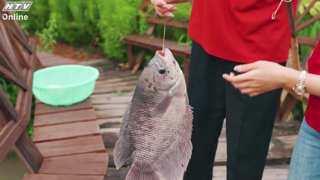

✅ Video L29_V020 trong Keyframes_L29: score = 0.1650 → frame 167 → D:/Summer_2025/AIC/Data_extraction/Keyframes_2025/Keyframes_L29\keyframes\L29_V020\168.jpg


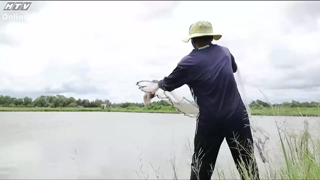

✅ Video L28_V007 trong Keyframes_L28: score = 0.1621 → frame 62 → D:/Summer_2025/AIC/Data_extraction/Keyframes_2025/Keyframes_L28\keyframes\L28_V007\063.jpg


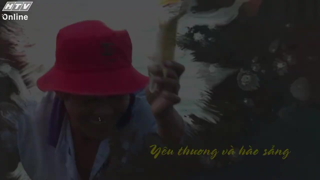

In [68]:
show_results = search_video(
    text_query="Một chiếc mồi câu đang thả xuống dưới nước. Miếng mồi này nhìn giống một con cá, màu bạc. Tiếp theo cảnh chuyển qua một người làm động tác nâng lên hạ xuống chiếc cần câu. Người này đang đội nón trắng. Video quay cảnh xung quanh thì cũng có nhiều người đang bắt cá. Có người bắt được một con cá và con cá này vùng vẫy khi bị câu lên.",
    feature_dir=r"D:/Summer_2025/AIC/Data_extraction/feature_new/",
    root_keyframes=r"D:/Summer_2025/AIC/Data_extraction/Keyframes_2025/",
    k=10
)

In [33]:
import faiss
import sqlite3
index = faiss.read_index(r"D:\Summer_2025\AIC\Data_extraction\index.faiss")
faiss.ParameterSpace().set_index_parameter(index, "nprobe", 256)

conn = sqlite3.connect(r"D:\Summer_2025\AIC\Data_extraction\meta.db")


In [54]:
def text_embed_faiss(text: str):

    ###### TEXT FEATURES EXTRACTING ######
    text = tokenizer(text).to(device)
    text_features = model.encode_text(text)

    text_features /= text_features.norm(dim=-1, keepdim=True)
    text_features = text_features.cpu().detach().numpy()
    # if text_features.ndim == 2 and text_features.shape[0] == 1:
    #     text_features = text_features.squeeze(0)   # từ (1,1152) -> (1152,)
    # elif text_features.ndim == 2 and text_features.shape[1] == 1:
    #     text_features = text_features.squeeze(1)   # từ (1152,1) -> (1152,)   
    # text_features = text_features.astype(np.float32)
    # text_features /= np.linalg.norm(text_features) + 1e-6
    return text_features


In [55]:
def search_vec(vec, k=10):
    D, I = index.search(vec, k)
    print(f"D {D}")
    print(f"I {I}")
    out = []
    for s, idx in zip(D[0].tolist(), I[0].tolist()):
        if idx == -1: continue
        row = conn.execute("SELECT path, payload FROM docs WHERE id=?", (int(idx),)).fetchone()
        if row:
            out.append({"id": int(idx), "score": float(s), "path": row[0], "payload": ujson.loads(row[1])})
    return out

In [69]:
text_query_faiss = "Một chiếc mồi câu đang thả xuống dưới nước. Miếng mồi này nhìn giống một con cá, màu bạc. Tiếp theo cảnh chuyển qua một người làm động tác nâng lên hạ xuống chiếc cần câu. Người này đang đội nón trắng. Video quay cảnh xung quanh thì cũng có nhiều người đang bắt cá. Có người bắt được một con cá và con cá này vùng vẫy khi bị câu lên."
text_query_faiss = translate_text_GoogleTranslate(text_query_faiss)
text_query_faiss = text_embed_faiss(text_query_faiss)

✅ Translation by Google Translate Library


In [70]:
import ujson
res = search_vec(text_query_faiss, k=10)
for r in res:
    print(f"{r['score']:.4f}\t{r['path']}")

D [[0.17439145 0.1685232  0.16828117 0.16812916 0.16621552 0.16581231
  0.16448313 0.1632051  0.16298847 0.16106082]]
I [[148960 151712 153108 149417 155263 152676 155774 150901 153930 149922]]
0.1744	Keyframes_L28/keyframes/L28_V003/062.jpg
0.1685	Keyframes_L28/keyframes/L28_V009/045.jpg
0.1683	Keyframes_L28/keyframes/L28_V012/054.jpg
0.1681	Keyframes_L28/keyframes/L28_V004/044.jpg
0.1662	Keyframes_L28/keyframes/L28_V017/064.jpg
0.1658	Keyframes_L28/keyframes/L28_V011/062.jpg
0.1645	Keyframes_L28/keyframes/L28_V018/064.jpg
0.1632	Keyframes_L28/keyframes/L28_V007/063.jpg
0.1630	Keyframes_L28/keyframes/L28_V014/046.jpg
0.1611	Keyframes_L28/keyframes/L28_V005/100.jpg
